In [1]:
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import warnings
warnings.simplefilter("ignore")

# # Data Set

In [2]:
numbers=[1,3,-6,5,-3]
numbers.sort()
output=[]
import math
min=math.inf
for i in range(len(numbers)-1):
    if numbers[i]<0 and numbers[i+1]>0:
        dif=numbers[i+1]-numbers[i]
    else:
        dif=abs(numbers[i]-numbers[i+1])
    if dif<min:
        min=dif
        output=[]
        output.append((numbers[i],numbers[i+1]))
    elif dif==min:
        output.append((numbers[i],numbers[i+1]))

for i,j in output:
    print(i,j)
        


1 3
3 5


In [3]:
station_day = pd.read_csv("./station_day.csv")

In [4]:
station_day.head(3)

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,NaN,NaN
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate


In [5]:
station_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108035 entries, 0 to 108034
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   StationId   108035 non-null  object 
 1   Date        108035 non-null  object 
 2   PM2.5       86410 non-null   float64
 3   PM10        65329 non-null   float64
 4   NO          90929 non-null   float64
 5   NO2         91488 non-null   float64
 6   NOx         92535 non-null   float64
 7   NH3         59930 non-null   float64
 8   CO          95037 non-null   float64
 9   SO2         82831 non-null   float64
 10  O3          82467 non-null   float64
 11  Benzene     76580 non-null   float64
 12  Toluene     69333 non-null   float64
 13  Xylene      22898 non-null   float64
 14  AQI         87025 non-null   float64
 15  AQI_Bucket  87025 non-null   object 
dtypes: float64(13), object(3)
memory usage: 13.2+ MB


# --------------------------------------- ARIMA ---------------------------------------

Arima model is a time series model . That means we can predcit how AQI change by time

In [6]:
arima_df = station_day[['Date','AQI']]

In [7]:
arima_df["Date"]= pd.to_datetime(arima_df["Date"])

In [8]:
arima_df.AQI = arima_df.groupby(pd.PeriodIndex(arima_df['Date'], freq="M"))['AQI'].apply(lambda x: x.fillna(x.mean()))

In [9]:
ts = arima_df.groupby(pd.PeriodIndex(arima_df['Date'], freq="M"))['AQI'].mean()

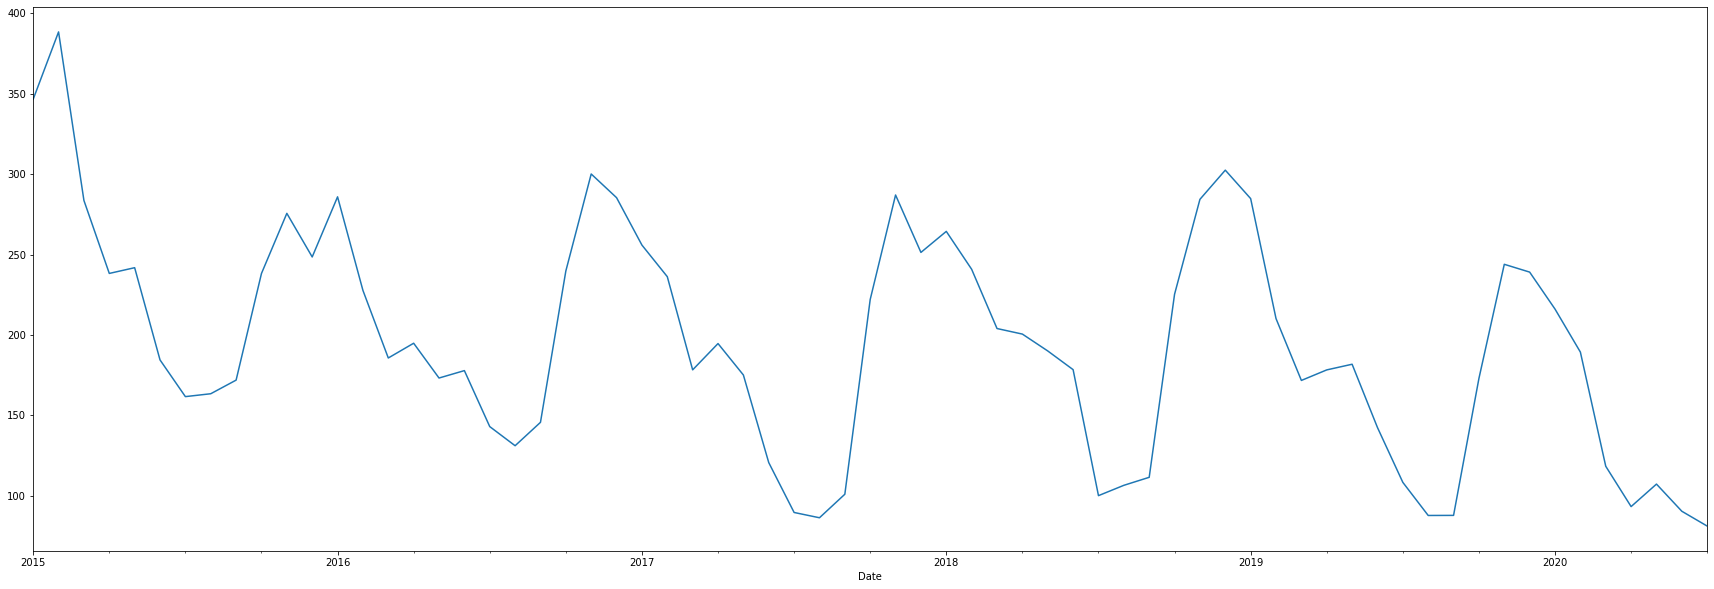

In [10]:
plt.figure(figsize = (30,10))
ts.plot()
plt.show()

**Doing adfuller test to identify the data set is stationay or not**

In [11]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.224505
p-value: 0.662967


In [12]:
ts_train = ts[:50]
ts_test = ts[50:]

In [13]:
from statsmodels.tsa.arima.model import ARIMA

In [14]:
import itertools
from sklearn.metrics import mean_squared_error

In [15]:
p = range(0,8)
q = range(0,8)
d = range(0,2)

In [16]:
pqd_combination = list(itertools.product(p,d,q))

In [17]:
error = []
pqd = []

In [ ]:
for i in pqd_combination:
    A_model = ARIMA(ts_train,order= i).fit()
    predict = A_model.predict(len(ts_train),len(ts)-1)
    e = np.sqrt(mean_squared_error(ts_test,predict))
    pqd.append(i)
    error.append(e)

In [19]:
min = error[0]
index = 0
for i in range(1,len(error)-1):
    if(min > error[i]):
        min = error[i]
        index = i
        
print(error[index],' => ',pqd[index])

48.48382894994655  =>  (7, 1, 1)


In [20]:
model_ts = ARIMA(ts_train, order=pqd[index])
model_ts_fit = model_ts.fit()
print(model_ts_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    AQI   No. Observations:                   50
Model:                 ARIMA(7, 1, 1)   Log Likelihood                -241.966
Date:                Wed, 26 Oct 2022   AIC                            501.931
Time:                        11:27:56   BIC                            518.957
Sample:                    01-31-2015   HQIC                           508.391
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7066      0.217      3.257      0.001       0.281       1.132
ar.L2         -0.2553      0.247     -1.036      0.300      -0.739       0.228
ar.L3         -0.1310      0.188     -0.697      0.4

In [21]:
arima_predict = model_ts_fit.predict(start = len(ts_train),end = len(ts))

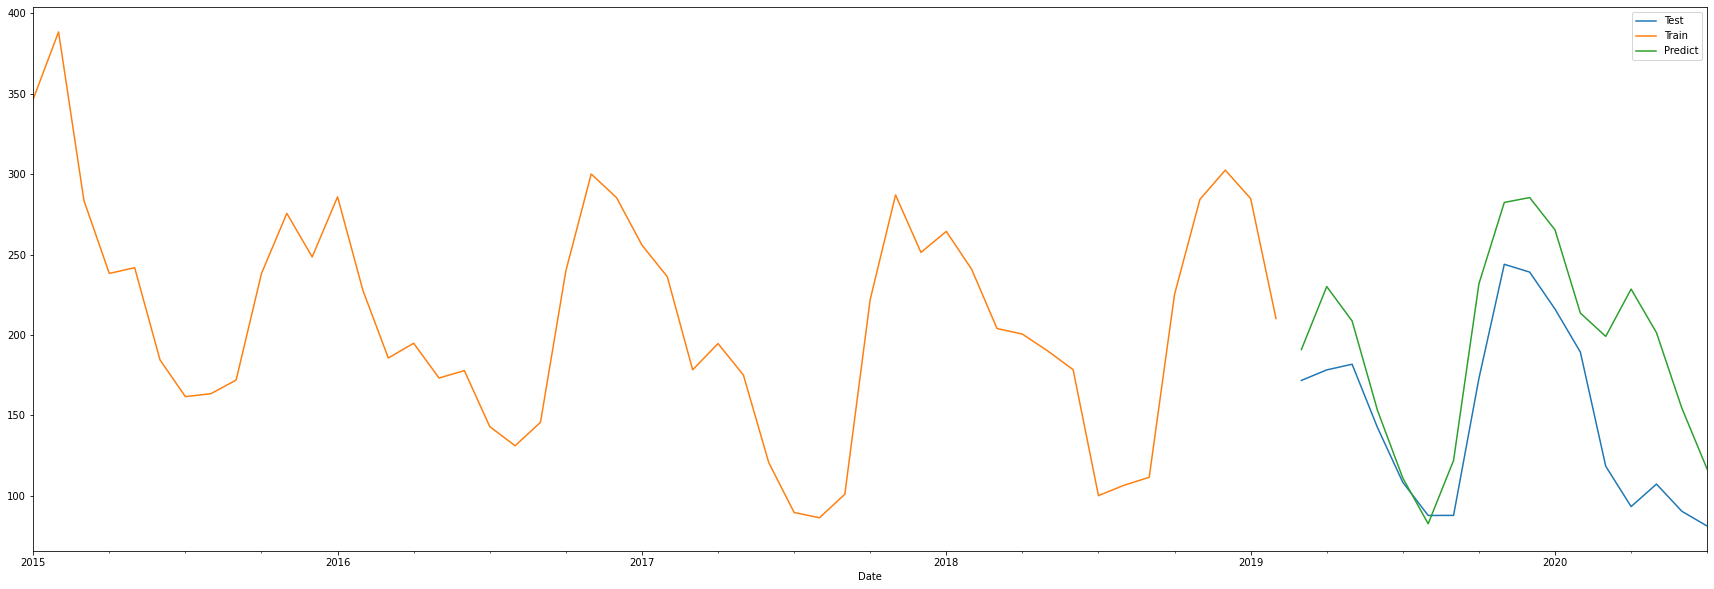

In [22]:
plt.figure(figsize = (30,10))
ts_test.plot(label = "Test")
ts_train.plot(label = "Train")
predict.plot(label = 'Predict')
plt.legend()
plt.show()

# ------------------------------- SARIM -------------------------------

In [23]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput )

Results of Dickey-Fuller Test:
Test Statistic                 -1.224505
p-value                         0.662967
#Lags Used                     10.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


*****This time series is not stationary. Because P > 0.05 .So we want to take first differntioal for series*****

In [24]:
df1_ts = ts - ts.shift(1)

In [25]:
df1_ts=df1_ts.dropna()

In [26]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df1_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput )

Results of Dickey-Fuller Test:
Test Statistic                -7.389944e+00
p-value                        8.050075e-11
#Lags Used                     9.000000e+00
Number of Observations Used    5.600000e+01
Critical Value (1%)           -3.552928e+00
Critical Value (5%)           -2.914731e+00
Critical Value (10%)          -2.595137e+00
dtype: float64


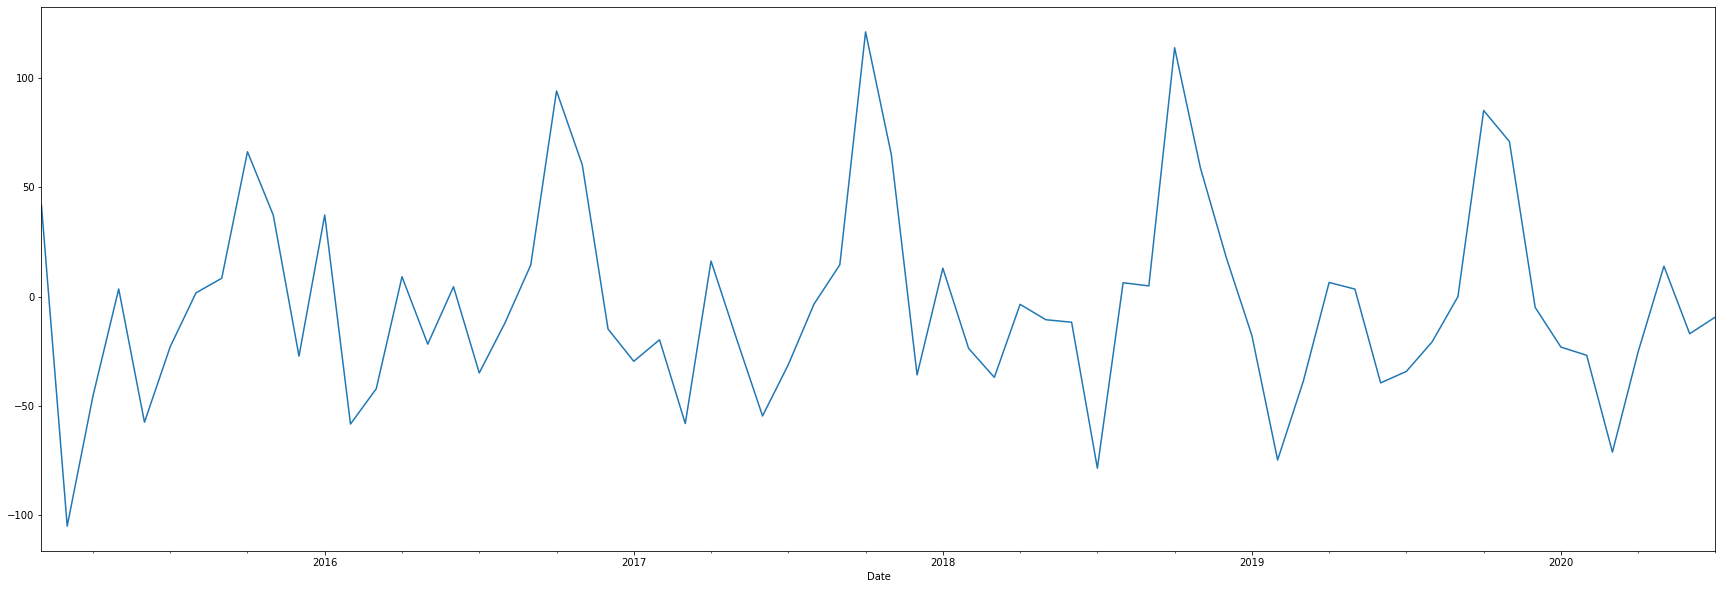

In [27]:
plt.figure(figsize = (30,10))
df1_ts.plot()
plt.show()

In [28]:
df1_ts_train = df1_ts[:50]
df1_ts_test = df1_ts[50:]

In [29]:
df_pdq = []
df_error = []

In [ ]:
for i in pqd_combination:
    A_model = ARIMA(df1_ts_train,order= i).fit()
    predict = A_model.predict(len(df1_ts_train),len(df1_ts)-1)
    e = np.sqrt(mean_squared_error(df1_ts_test,predict))
    df_pdq.append(i)
    df_error.append(e)

In [31]:
min = df_error[0]
index = 0
for i in range(1,len(df_error)-1):
    if(min > df_error[i]):
        min = df_error[i]
        index = i
        
print(df_error[index],' => ',df_pdq[index])

20.36012104806701  =>  (5, 0, 7)


In [32]:
import statsmodels.api as sm

In [33]:
sarima_model = sm.tsa.statespace.SARIMAX(df1_ts_train, trend='n', order=(7,0,3), seasonal_order=(1,1,1,12))
s_results = sarima_model.fit()
print(s_results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  AQI   No. Observations:                   50
Model:             SARIMAX(7, 0, 3)x(1, 1, [1], 12)   Log Likelihood                -176.699
Date:                              Wed, 26 Oct 2022   AIC                            379.398
Time:                                      11:28:32   BIC                            400.686
Sample:                                  02-28-2015   HQIC                           386.972
                                       - 03-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2079      1.964     -0.106      0.916      -4.057       3.641
ar.L2         -0.99

C:\Users\chath\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
s_pred = s_results.predict(start = len(df1_ts_train),end = len(df1_ts)-1)

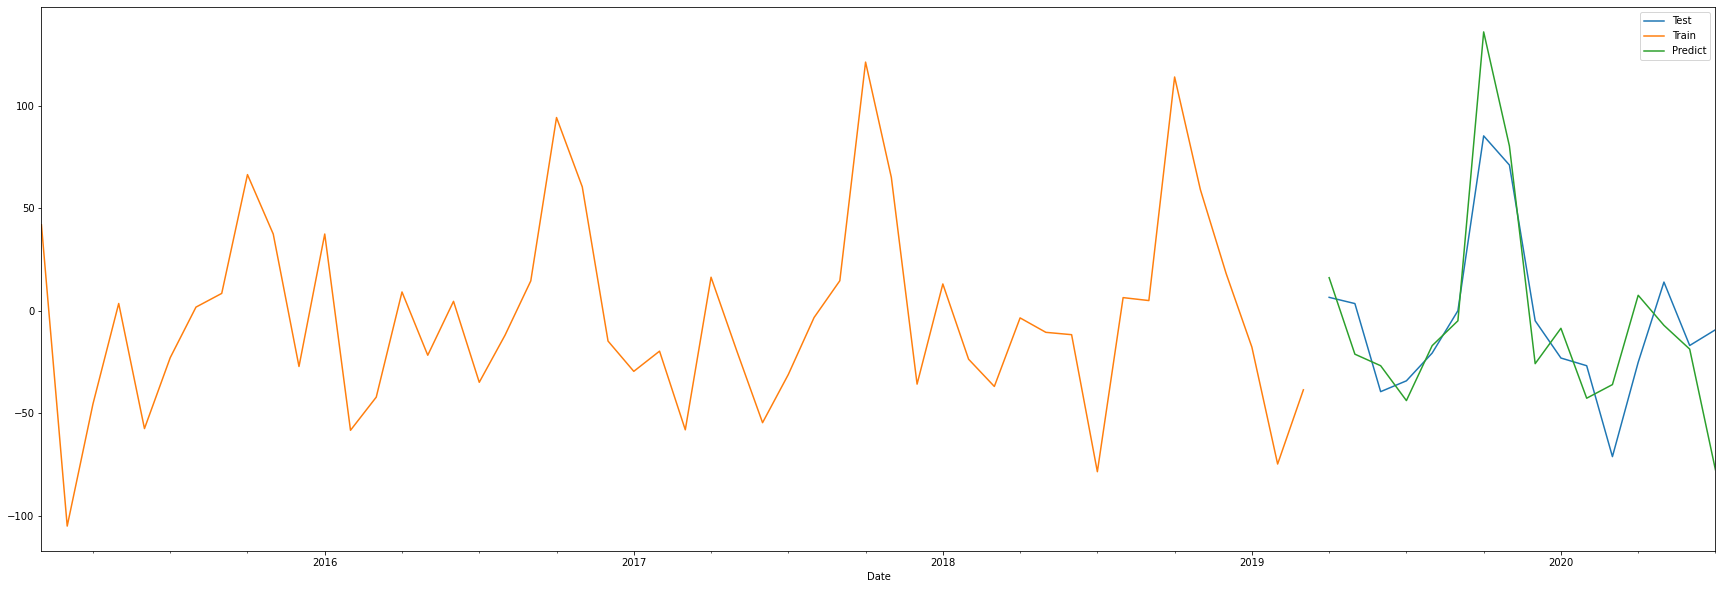

In [35]:
plt.figure(figsize = (30,10))
df1_ts_test.plot(label = "Test")
df1_ts_train.plot(label = "Train")
s_pred.plot(label = 'Predict')
plt.legend()
plt.show()

# ------------------------------------- FB Prophet -------------------------------------

FB prophet is using for time series forcasting . So we want to use date column and AQI bucket column only

In [36]:
from prophet import Prophet

In [37]:
%pip install --upgrade plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [38]:
alt_fb_df = station_day[['Date','AQI']]

In [39]:
alt_fb_df["Date"]= pd.to_datetime(alt_fb_df["Date"])

In [40]:
alt_fb_df.AQI = alt_fb_df.groupby(pd.PeriodIndex(alt_fb_df['Date'], freq="M"))['AQI'].apply(lambda x: x.fillna(x.mean()))

In [41]:
alt_fb_df = alt_fb_df.rename(columns={'Date':'ds','AQI':'y'})

In [42]:
alt_fb_df_train = alt_fb_df[:-26108]
alt_fb_df_test = alt_fb_df[len(alt_fb_df)-26108:]

In [43]:
alt_fbp = Prophet(daily_seasonality = True)
alt_fbp.fit(alt_fb_df_train)



11:28:37 - cmdstanpy - INFO - Chain [1] start processing
11:30:05 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
alt_future = alt_fbp.make_future_dataframe(periods=365)

In [45]:
alt_forecast = alt_fbp.predict(alt_future)

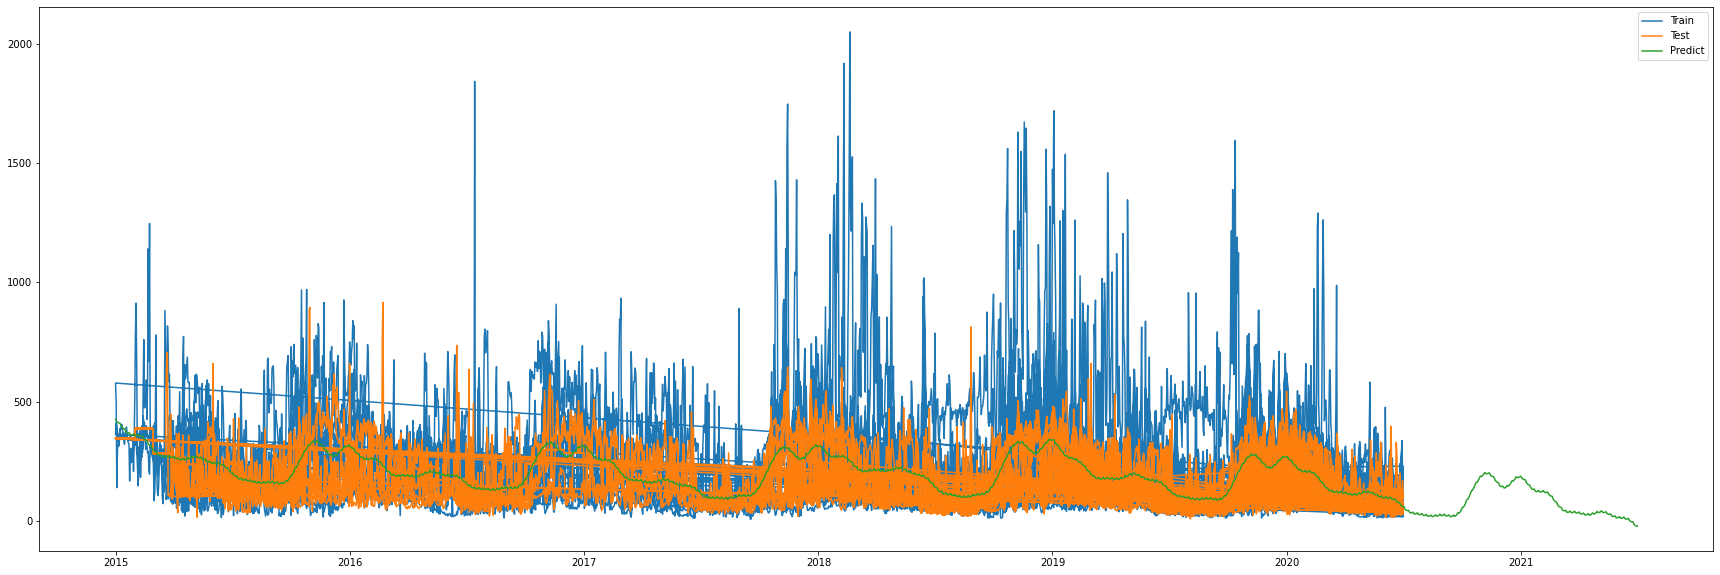

In [46]:
plt.figure(figsize = (30,10))
plt.plot(alt_fb_df_train['ds'],alt_fb_df_train['y'],label = "Train")
plt.plot(alt_fb_df_test['ds'],alt_fb_df_test['y'],label = "Test")
plt.plot(alt_forecast['ds'],alt_forecast['yhat'],label = 'Predict')
plt.legend()
plt.show()


# ---------------------------------------- LSTM ----------------------------------------

In [47]:
station_day.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,86410.000000,65329.000000,90929.000000,91488.000000,92535.000000,59930.000000,95037.000000,82831.000000,82467.000000,76580.000000,69333.000000,22898.000000,87025.000000
mean,80.272571,157.968427,23.123424,35.240760,41.195055,28.732875,1.605749,12.257634,38.134836,3.358029,15.345394,2.423446,179.749290
std,76.526403,123.418672,34.491019,29.510827,45.145976,24.897797,4.369578,12.984723,39.128004,11.156234,29.348587,6.472409,131.324339
min,0.020000,0.010000,0.010000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,8.000000
25%,31.880000,70.150000,4.840000,15.090000,13.970000,11.900000,0.530000,5.040000,18.895000,0.160000,0.690000,0.000000,86.000000
50%,55.950000,122.090000,10.290000,27.210000,26.660000,23.590000,0.910000,8.950000,30.840000,1.210000,4.330000,0.400000,132.000000
75%,99.920000,208.670000,24.980000,46.930000,50.500000,38.137500,1.450000,14.920000,47.140000,3.610000,17.510000,2.110000,254.000000
max,1000.000000,1000.000000,470.000000,448.050000,467.630000,418.900000,175.810000,195.650000,963.000000,455.030000,454.850000,170.370000,2049.000000


In [48]:
lstm_df = station_day

In [49]:
lstm_df["Date"]= pd.to_datetime(lstm_df["Date"])

In [50]:
lstm_df.drop(['AQI_Bucket', 'StationId'], axis=1, inplace=True)

In [51]:
lstm_df=lstm_df.dropna()

In [52]:
lstm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10314 entries, 1 to 106147
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     10314 non-null  datetime64[ns]
 1   PM2.5    10314 non-null  float64       
 2   PM10     10314 non-null  float64       
 3   NO       10314 non-null  float64       
 4   NO2      10314 non-null  float64       
 5   NOx      10314 non-null  float64       
 6   NH3      10314 non-null  float64       
 7   CO       10314 non-null  float64       
 8   SO2      10314 non-null  float64       
 9   O3       10314 non-null  float64       
 10  Benzene  10314 non-null  float64       
 11  Toluene  10314 non-null  float64       
 12  Xylene   10314 non-null  float64       
 13  AQI      10314 non-null  float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 1.2 MB


In [53]:
dates = lstm_df['Date']
lstm_df.drop('Date', axis=1,inplace=True)

In [54]:
x_test_df = lstm_df.drop(columns =['AQI'])


In [55]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [56]:

col_names = []
for i in lstm_df.columns:
    lstm_df[i] = min_max_scaler.fit_transform(lstm_df[i].values.reshape(-1,1))


# df['Col1_scaled'] = scaler.fit_transform(df['Col1'].values.reshape(-1,1))

In [57]:
lstm_df.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000,10314.000000
mean,0.070067,0.124616,0.046511,0.130229,0.090175,0.063002,0.147519,0.146026,0.198364,0.026781,0.046792,0.021425,0.153620
std,0.058763,0.082347,0.072069,0.089924,0.085037,0.047205,0.092177,0.118020,0.122841,0.081127,0.091783,0.052759,0.111058
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.033607,0.069053,0.010039,0.059701,0.038192,0.034216,0.088608,0.063580,0.113062,0.001390,0.005366,0.000898,0.082840
50%,0.057685,0.112861,0.023857,0.112101,0.067817,0.050958,0.132911,0.115545,0.173814,0.009189,0.019341,0.006587,0.130178
75%,0.088783,0.160212,0.051187,0.181183,0.110580,0.081051,0.189873,0.189250,0.254960,0.025150,0.048131,0.022081,0.181953
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
x = lstm_df.drop(columns =['AQI'])
y = lstm_df['AQI']

In [59]:
dates = np.array(dates)
dates

array(['2017-11-25T00:00:00.000000000', '2017-11-26T00:00:00.000000000',
       '2017-11-27T00:00:00.000000000', ...,
       '2020-02-12T00:00:00.000000000', '2020-02-13T00:00:00.000000000',
       '2020-02-14T00:00:00.000000000'], dtype='datetime64[ns]')

In [60]:
x = np.array(x)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

In [61]:
y = np.array(y)
y = y.reshape(-1,)

In [62]:
dates_train, x_train, y_train = dates[:8500], x[:8500], y[:8500]
dates_test, x_test, y_test = dates[8500:], x[8500:], y[8500:]

In [63]:
x_test.shape

(1814, 12, 1)

In [64]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import InputLayer

model_lstm = Sequential()

model_lstm.add(InputLayer((12,1)))

model_lstm.add(LSTM(50,return_sequences=True))

model_lstm.add(LSTM(34 ,return_sequences=True))
model_lstm.add(Dropout(0.25))

model_lstm.add(LSTM(15))

model_lstm.add(Dense(1 ,'linear' ))

In [65]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 12, 34)            11560     
                                                                 
 dropout (Dropout)           (None, 12, 34)            0         
                                                                 
 lstm_2 (LSTM)               (None, 15)                3000      
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 24,976
Trainable params: 24,976
Non-trainable params: 0
_________________________________________________________________


In [66]:
model_lstm.compile(
    optimizer = 'adam',
    loss = 'mse',
    metrics = ['accuracy']
)

In [67]:
lstm_history = model_lstm.fit(x_train,y_train,validation_split=0.33 , epochs = 10)

Epoch 1/10
178/178 [==============================] - 7s 16ms/step - loss: 0.0066 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 3.5638e-04
Epoch 2/10
178/178 [==============================] - 2s 11ms/step - loss: 0.0035 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 3.5638e-04
Epoch 3/10
178/178 [==============================] - 2s 11ms/step - loss: 0.0030 - accuracy: 1.7562e-04 - val_loss: 0.0020 - val_accuracy: 3.5638e-04
Epoch 4/10
178/178 [==============================] - 2s 11ms/step - loss: 0.0026 - accuracy: 1.7562e-04 - val_loss: 9.2489e-04 - val_accuracy: 3.5638e-04
Epoch 5/10
178/178 [==============================] - 2s 11ms/step - loss: 0.0024 - accuracy: 1.7562e-04 - val_loss: 7.9994e-04 - val_accuracy: 3.5638e-04
Epoch 6/10
178/178 [==============================] - 2s 11ms/step - loss: 0.0020 - accuracy: 1.7562e-04 - val_loss: 6.1397e-04 - val_accuracy: 3.5638e-04
Epoch 7/10
178/178 [==============================] - 2s 11ms/step - loss: 0.0019 

In [68]:
lstm_y_pred = model_lstm.predict(x_test)

57/57 [==============================] - 1s 3ms/step


In [69]:
lstm_y_pred =lstm_y_pred.reshape(-1,)

In [70]:
type(lstm_y_pred)

numpy.ndarray

In [71]:
minimo = 8.000000
maximo = 2049.000000

In [72]:
new_lstm_y_pred=lstm_y_pred * minimo + (maximo - minimo)

In [73]:
np.min(new_lstm_y_pred)

2041.1239

In [74]:
# x_test_df[lstm_y_pred] = lstm_y_pred

In [75]:
x_test_df.shape

(10314, 12)

In [76]:
# lstm_y_pred=lstm_y_pred.reshape(-1,)

In [77]:
# lstm_y_pred = (lstm_y_pred-np.min(lstm_y_pred))/(np.max(lstm_y_pred)-np.min(lstm_y_pred))

In [78]:
# lstm_y_pred

In [79]:
# x_test.shape

In [80]:
# new_min_max_scaler = preprocessing.MinMaxScaler()

In [81]:
# lstm_y_pred=lstm_y_pred.reshape(-1,)

In [82]:
# x_test.shape

In [83]:
# lstm_y_pred = pd.DataFrame(lstm_y_pred) 

In [84]:
# x_test_df = x_test_df.assign(lstm_y_pred=lstm_y_pred)

In [85]:
# x_test_df[lstm_y_pred] = lstm_y_pred

In [86]:
# lstm_pred_df = x_test_df.merge(lstm_y_pred) 

In [87]:
# lstm_y_pred=min_max_scaler.inverse_transform(lstm_y_pred)

In [88]:
# lstm_y_pred

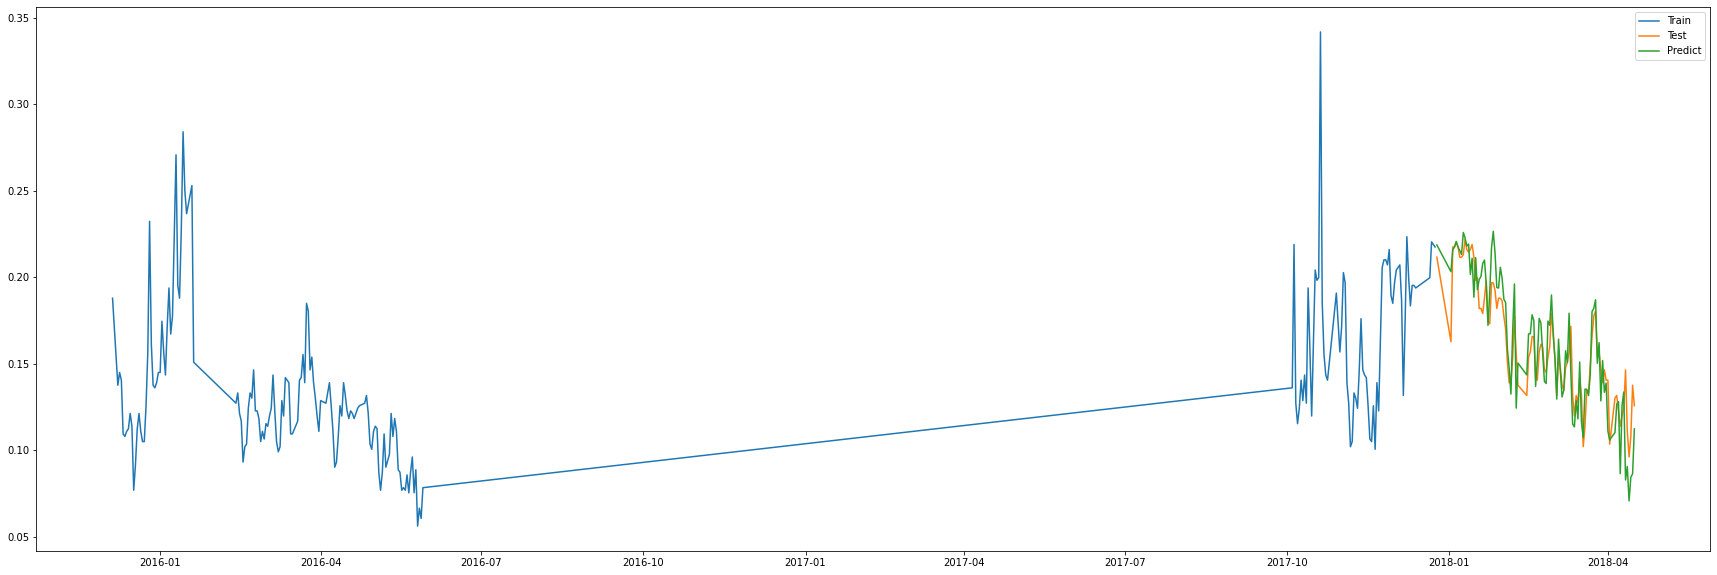

In [89]:
plt.figure(figsize = (30,10))
plt.plot(dates_train[-210:],y_train[-210:],label = "Train")
plt.plot(dates_test[:100],y_test[:100],label = "Test")
plt.plot(dates_test[:100],lstm_y_pred[:100],label = 'Predict')
plt.legend()
plt.show()


# ----------------------------------------- GRU ----------------------------------------

In [90]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import InputLayer

model_gru = Sequential()

model_gru.add(InputLayer((12,1)))

model_gru.add(GRU(50,return_sequences=True))

model_gru.add(GRU(26 ,return_sequences=True))
# model_lstm.add(Dropout(0.25))

model_gru.add(GRU(10))

model_gru.add(Dense(1,'linear' ))


In [91]:
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 12, 50)            7950      
                                                                 
 gru_1 (GRU)                 (None, 12, 26)            6084      
                                                                 
 gru_2 (GRU)                 (None, 10)                1140      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 15,185
Trainable params: 15,185
Non-trainable params: 0
_________________________________________________________________


In [92]:
model_gru.compile(
    optimizer = 'adam',
    loss = 'mse',
    metrics = ['accuracy']
)

In [93]:
gru_history = model_gru.fit(x_train,y_train,validation_split=0.33 , epochs = 10)

Epoch 1/10
178/178 [==============================] - 7s 18ms/step - loss: 0.0087 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 3.5638e-04
Epoch 2/10
178/178 [==============================] - 2s 13ms/step - loss: 0.0031 - accuracy: 1.7562e-04 - val_loss: 0.0016 - val_accuracy: 3.5638e-04
Epoch 3/10
178/178 [==============================] - 2s 13ms/step - loss: 0.0026 - accuracy: 1.7562e-04 - val_loss: 0.0012 - val_accuracy: 3.5638e-04
Epoch 4/10
178/178 [==============================] - 3s 15ms/step - loss: 0.0023 - accuracy: 1.7562e-04 - val_loss: 9.5957e-04 - val_accuracy: 3.5638e-04
Epoch 5/10
178/178 [==============================] - 2s 12ms/step - loss: 0.0022 - accuracy: 1.7562e-04 - val_loss: 0.0011 - val_accuracy: 3.5638e-04
Epoch 6/10
178/178 [==============================] - 2s 13ms/step - loss: 0.0020 - accuracy: 1.7562e-04 - val_loss: 9.8640e-04 - val_accuracy: 3.5638e-04
Epoch 7/10
178/178 [==============================] - 2s 11ms/step - loss: 0.0019 - ac

In [94]:
model_gru.evaluate(x_test, y_test)

57/57 [==============================] - 0s 3ms/step - loss: 0.0020 - accuracy: 0.0000e+00


[0.0019858202431350946, 0.0]

In [95]:
gru_y_pred = model_gru.predict(x_test)

57/57 [==============================] - 1s 3ms/step


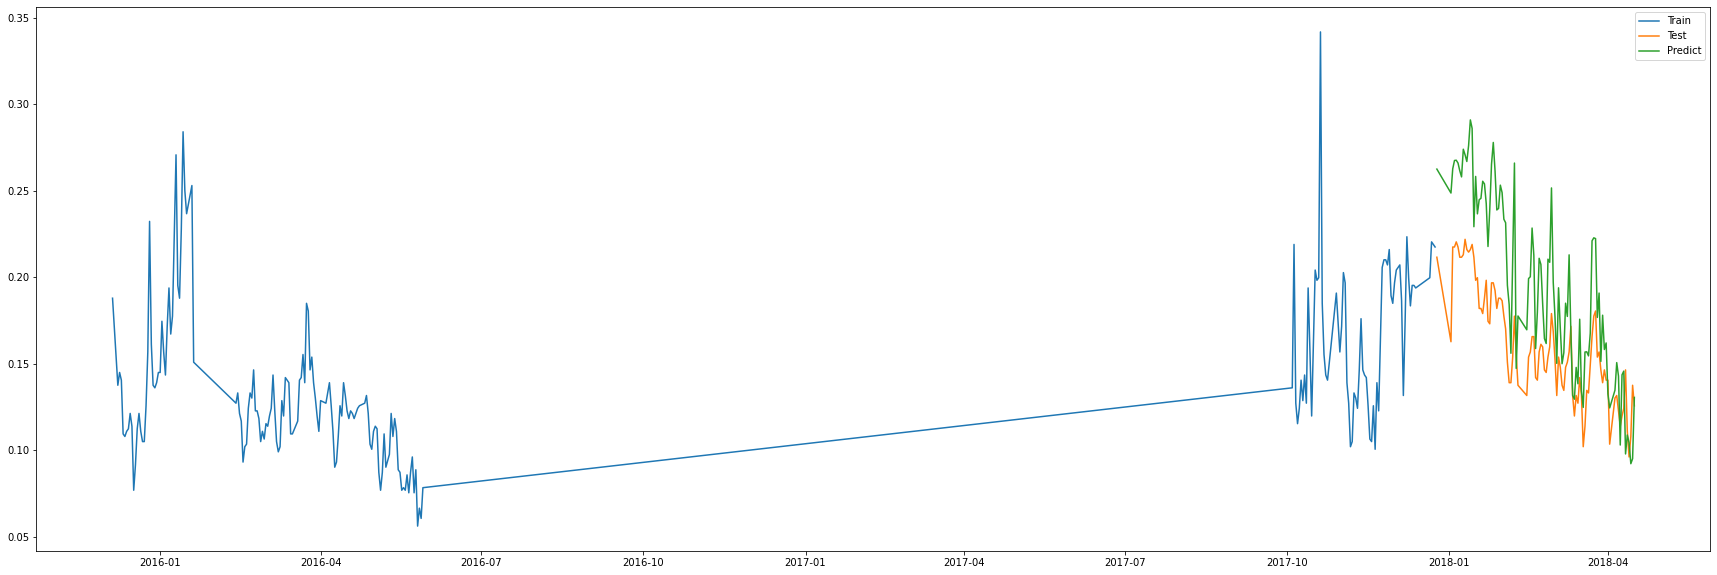

In [96]:
plt.figure(figsize = (30,10))
plt.plot(dates_train[-210:],y_train[-210:],label = "Train")
plt.plot(dates_test[:100],y_test[:100],label = "Test")
plt.plot(dates_test[:100],gru_y_pred[:100],label = 'Predict')
plt.legend()
plt.show()


# ***Root Mean Squared Error***

In [97]:
from sklearn.metrics import mean_squared_error

In [98]:
arima_RMSE = mean_squared_error(ts_test,arima_predict[:17])
sarima_RMSE = mean_squared_error(df1_ts_test,s_pred)
# fbpropet_RMSE = mean_squared_error(alt_fb_df_test,alt_forecast)
lstm_RMSE = mean_squared_error(y_test,lstm_y_pred)
gru_RMSE = mean_squared_error(y_test, gru_y_pred)

In [99]:
print("arima_RMSE => ", arima_RMSE**0.5)
print("sarima_RMSE => ", sarima_RMSE**0.5)
print("lstm_RMSE => ", lstm_RMSE**0.5)
print("gru_RMSE => ", gru_RMSE**0.5)

arima_RMSE =>  48.48382894994655
sarima_RMSE =>  27.314622843214288
lstm_RMSE =>  0.03887889485919017
gru_RMSE =>  0.04456254267491321


# ***Mean Relative Error***

# ***Mean Absolute Percentage Error***

In [100]:
from sklearn.metrics import mean_absolute_percentage_error

In [101]:
arima_MAPE = mean_absolute_percentage_error(ts_test,arima_predict[:17])
sarima_MAPE = mean_absolute_percentage_error(df1_ts_test,s_pred)
# fbpropet_RMSE = mean_squared_error(alt_fb_df_test,alt_forecast)
lstm_MAPE = mean_absolute_percentage_error(y_test,lstm_y_pred)
gru_MAPE = mean_absolute_percentage_error(y_test, gru_y_pred)

In [102]:
print("arima_MAPE => ", arima_MAPE)
print("sarima_MAPE => ", sarima_MAPE)
print("lstm_MAPE => ", lstm_MAPE)
print("gru_MAPE => ", gru_MAPE)

arima_MAPE =>  0.3638161348062271
sarima_MAPE =>  7.744287938786577
lstm_MAPE =>  0.21808731507172777
gru_MAPE =>  0.327477383215591


# ***Mean Squared Error***

In [103]:
from sklearn.metrics import mean_squared_error

In [104]:
arima_RMSE = mean_squared_error(ts_test,arima_predict[:17])
sarima_RMSE = mean_squared_error(df1_ts_test,s_pred)
# fbpropet_RMSE = mean_squared_error(alt_fb_df_test,alt_forecast)
lstm_RMSE = mean_squared_error(y_test,lstm_y_pred)
gru_RMSE = mean_squared_error(y_test, gru_y_pred)

In [105]:
print("arima_MSE => ", arima_RMSE)
print("sarima_MSE => ", sarima_RMSE)
print("lstm_MSE => ", lstm_RMSE)
print("gru_MSE => ", gru_RMSE)

arima_MSE =>  2350.681669647675
sarima_MSE =>  746.0886210670437
lstm_MSE =>  0.0015115684654719635
gru_MSE =>  0.001985820209653461


# ***Mean Absolute Error***

In [106]:
from sklearn.metrics import mean_absolute_error

In [107]:
arima_MAE = mean_absolute_error(ts_test,arima_predict[:17])
sarima_MAE = mean_absolute_error(df1_ts_test,s_pred)
# fbpropet_RMSE = mean_squared_error(alt_fb_df_test,alt_forecast)
lstm_MAE = mean_absolute_error(y_test,lstm_y_pred)
gru_MAE = mean_absolute_error(y_test, gru_y_pred)

In [108]:
print("arima_MAE => ", arima_MAE)
print("sarima_MAE => ", sarima_MAE)
print("lstm_MAE => ", lstm_MAE)
print("gru_MAE => ", gru_MAE)

arima_MAE =>  39.7157454927646
sarima_MAE =>  20.933186206910484
lstm_MAE =>  0.0262652542436129
gru_MAE =>  0.0337195516495374


# ***Root Relative Squared Error***

# ***Mean Relative Error***

# ------------------------------------ LSTM / GRU ------------------------------------

In [109]:
dates_train, x_train, y_train = dates[:1500], x[:1500], y[:1500]
dates_test, x_test, y_test = dates[1500:], x[1500:], y[1500:]

In [110]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import GRU
# from keras.layers import Dropout
# from keras.layers import InputLayer

lstm_gru = Sequential()

lstm_gru.add(InputLayer((12,1)))

lstm_gru.add(LSTM(50,return_sequences=True))
lstm_gru.add(GRU(45,return_sequences=True))
lstm_gru.add(GRU(26,return_sequences=True))
lstm_gru.add(LSTM(10,return_sequences=True))
lstm_gru.add(LSTM(3))

lstm_gru.add(Dense(1 ))

In [111]:
# lstm_gru = keras.Sequential([
#     keras.layers.InputLayer(input_shape = (12,1)),
#     keras.layers.LSTM(50,return_sequences=True),
#     keras.layers.GRU(35),
#     keras.layers.Dense(50 , activation = "relu"),
#     keras.layers.Dense(27 , activation = "relu"),
#     keras.layers.Dense(12 , activation = "relu"),
#     keras.layers.Dense(1 , activation = "linear"),
# ])


In [112]:
lstm_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 12, 50)            10400     
                                                                 
 gru_3 (GRU)                 (None, 12, 45)            13095     
                                                                 
 gru_4 (GRU)                 (None, 12, 26)            5694      
                                                                 
 lstm_4 (LSTM)               (None, 12, 10)            1480      
                                                                 
 lstm_5 (LSTM)               (None, 3)                 168       
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 30,841
Trainable params: 30,841
Non-trai

In [113]:
lstm_gru.compile(
    optimizer = 'adam',
    loss = 'mse',
    metrics = ['accuracy']
)

In [114]:
lstm_gru_history = lstm_gru.fit(x_train,y_train, epochs = 10)

Epoch 1/10
47/47 [==============================] - 8s 18ms/step - loss: 0.0086 - accuracy: 0.0000e+00
Epoch 2/10
47/47 [==============================] - 1s 16ms/step - loss: 0.0035 - accuracy: 0.0000e+00
Epoch 3/10
47/47 [==============================] - 1s 16ms/step - loss: 0.0025 - accuracy: 0.0000e+00
Epoch 4/10
47/47 [==============================] - 1s 15ms/step - loss: 0.0024 - accuracy: 0.0000e+00
Epoch 5/10
47/47 [==============================] - 1s 16ms/step - loss: 0.0023 - accuracy: 0.0000e+00
Epoch 6/10
47/47 [==============================] - 1s 16ms/step - loss: 0.0022 - accuracy: 0.0000e+00
Epoch 7/10
47/47 [==============================] - 1s 15ms/step - loss: 0.0020 - accuracy: 0.0000e+00
Epoch 8/10
47/47 [==============================] - 1s 15ms/step - loss: 0.0019 - accuracy: 0.0000e+00
Epoch 9/10
47/47 [==============================] - 1s 15ms/step - loss: 0.0018 - accuracy: 0.0000e+00
Epoch 10/10
47/47 [==============================] - 1s 17ms/step - loss:

In [115]:
lstm_gru.evaluate(x_test, y_test)

276/276 [==============================] - 3s 4ms/step - loss: 0.0028 - accuracy: 1.1346e-04


[0.0027808446902781725, 0.00011345586244715378]

In [116]:
lstm_gru_y_pred = lstm_gru.predict(x_test)

276/276 [==============================] - 3s 5ms/step


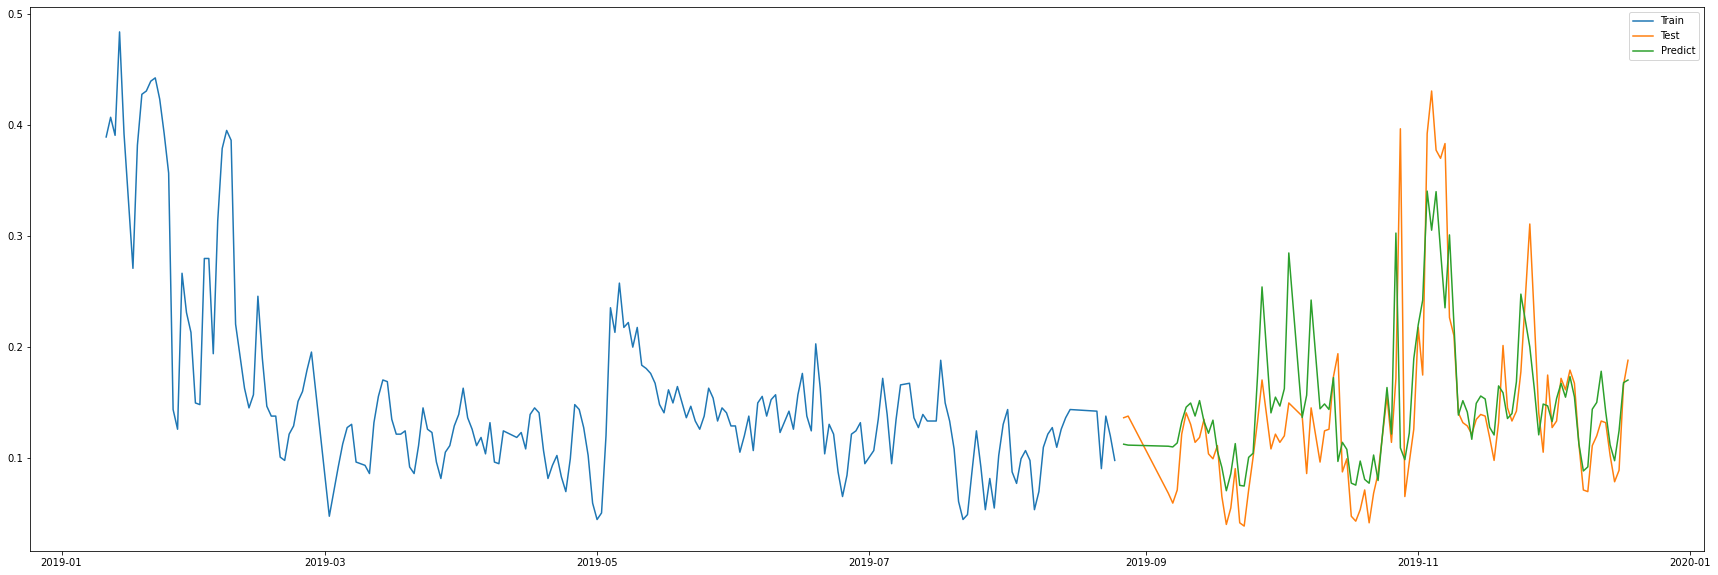

In [117]:
plt.figure(figsize = (30,10))
plt.plot(dates_train[-210:],y_train[-210:],label = "Train")
plt.plot(dates_test[:100],y_test[:100],label = "Test")
plt.plot(dates_test[:100],lstm_gru_y_pred[:100],label = 'Predict')
plt.legend()
plt.show()


# ***Mean Squared Error***

In [118]:
from sklearn.metrics import mean_squared_error

In [119]:
lstm_gru_MSE = mean_squared_error(y_test, lstm_gru_y_pred)

In [120]:
print("lstm_gru_MSE => ", lstm_gru_MSE)

lstm_gru_MSE =>  0.0027808443944414485


# ***Root Mean Squared Error***

In [121]:
print("lstm_gru_RMSE => ", lstm_gru_MSE**0.5)

lstm_gru_RMSE =>  0.05273371212461198
